# Analýza hier na platforme Steam
Autor: Daniel Ďurica <br>
Matematicko-fyzikální fakulta, Karlova Univerzita Praha 2024
## Introdukcia
V tejto analýze by som sa chcel podívať na dáta získané zo Steam API. Chcel by som získať informácie o počtu ich aktuálnych hráčov, a zistiť ako sa správa táto premenná pri rôznych pozorovaniach. Budú ma zaujímať tieto nulové hypotézy. <br>
1. Je počet hráčov hrajúci singleplayer hry rovnaký ako počet hráčov hrajúci multiplayer hry 
2. Koreluje vek hry s nižším počtom hráčov. 
3. Koresponduje priemerný počet hráčov na žáner s percentom hier spravených na daný žáner. 

## Includes

In [1]:
from typing import List
from random import Random
import json
import os
import shutil
import requests
import scipy.stats as stats
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

## Spracovanie dát
Aby som získal dáta z API, najskôr som musel získať list všetkých APPIDs. Pripravil som si na to túto funkciu.

In [2]:
appid_file = 'GameList.txt' # File with all app ids
directory = "Apps" # Directory of app infos
games_directory = "Games" # Directory of game info
player_count_file = "playercount.txt" # File with playercounts of games

In [3]:
class Response:
    value = None
    status_code : int
    def __init__(self, value, status_code : int):
        self.value = value
        self.status_code = status_code
        
def get_app_list() -> Response:
    # Get the list of all games on Steam
    app_list_url = 'https://api.steampowered.com/ISteamApps/GetAppList/v2/'
    response = requests.get(app_list_url)
    
    if response.status_code != 200:
        print("Error getting app list")
        return Response(None, response.status_code)
    
    app_list = response.json()
    app_ids = [app['appid'] for app in app_list['applist']['apps']]
    return Response(app_ids, 200)

def dump_ls_to_file(ls: List, loc : str):
    f = open(loc, "w")
    for item in ls:
        f.write(str(item))
        f.write("\n")

In [4]:
response = get_app_list()
if response.status_code == 200:
    dump_ls_to_file(response.value, appid_file)

Keď som získal APPIDs, bolo ich vyše 210 tisíc. Prvotne som chcel pracovať s každou jednou hrou aká na obchode Steam je. Bohužial narazil som na 2 problémy. <br>
1. Napriek tomu že v dokumentácii o Steam API je napísané že sa dá získať informácie o viac hrách naraz, v skutočnosti túto funkcionalitu zrušili a momentálne funguje len ak chceme získať cenu produktov. Toto však ale sám o sebe nie je problém, keďže by som si len pripravil skript, ktorý mi získa dáta a nechal ho bežať v pozadí. Problém však nastane lebo...
2. Steam API má timeout po ~180 volaniach. Tento timeout je priblyžne 3 minútový.
Keď zvážim tieto 2 problémy a vypočítam si že ak chcem získať všetky hry tak potrebujem nechať program spustený minimálne 2 a pol dňa, musel som sa rozhodnúť ako inak chcem vyriešiť tento problém.

Pochopitelne riešenie problému bolo spraviť výber z týchto dát. Chcel som aby výber mal čo najmenší bias a aby mal čo najväčšie pokrytie. Taktieź som chcel aby bol jednoduchý na implementáciu a preto som sa rozhodol o Stratifikovaný výber, so skupinami s rovnokou velkosťou. Tento výber je celkom zložité zahusťovať, ale zato zaistí aby som mal nulový bias a maximálne pokrytie.

Tu sú funkcie, ktoré získajú a uložia informácie o hrách.

In [4]:
def save_game_details(game) -> None:
    f = open(f"{directory}/{game['steam_appid']}.txt", "w")
    f.write(json.dumps(game))

def get_sample_interval(ls : List, samples: int) -> (int, int):
    ln = len(ls)
    if (ln <= samples): return (1, 0)
    interval = ln // samples
    remainder = ln - interval*samples
    return (interval, remainder)

def get_app_list_from_file(loc: str) -> List:
    f = open(loc, "r")
    ls = f.readlines()
    rs = []
    for line in ls:
        rs.append(line.rstrip('\n'))
    return rs

def get_app_info(game_id : str) -> Response:
    app_details_url = f'https://store.steampowered.com/api/appdetails?appids={game_id}'
    response = requests.get(app_details_url)
    if response.status_code == 200:
        details = response.json()
        if details[str(game_id)]['success']:
            return Response(details[str(game_id)]['data'], 200)
        else:
            return Response(None, 0)    
    else:
        print(f"Error getting details for app {game_id}")
        return Response(None, response.status_code)    

def get_apps_info(samples : int):
    apps = get_app_list_from_file(appid_file)
    print("Number of all apps: " + str(len(apps)))
    rnd = Random()
    sampled_games = []

    interval = get_sample_interval(apps, samples)
    print("Sample Stratum size: " + str(interval[0]))

    for i in range(0, len(apps) - interval[0], interval[0]):
        passed = False
        counter = 0
        while (passed == False):
            gm = rnd.randrange(i, i + interval[0])
            if gm < len(apps):
                rs = get_app_info(apps[gm])
            else: rs = Response(None, 0)
            if (rs.status_code == 200):
                passed = True
                sampled_games.append(apps[gm])
                save_game_details(rs.value)
            elif rs.status_code != 0:
                sleep(180)
            else:
                counter += 1
                if counter == 10:
                    passed = True
                    print("The Interval is Invalid")

 Pre testy som sa rozhodol získať 10000 vzorkov (po vyfiltrovaní hier zostalo 6000). Je to málo oproti originálnych 210000, avšak tu využijem CLT, ktorá hovorí že výberový priemer bude pre môj výber približne v normálnom rozdelení a preto, pre jednoduché testy by mi malo teda stačiť aj tých 6000 vzorkov.

Pre ukážku fungovania kódu požijem 100 vzorkov, avšak dalej budem pracovať s originálnym výberom.

In [6]:
old_directory = directory 
directory = "Example_Apps"
get_apps_info(100)
directory = old_directory

Number of all apps: 210461
Sample Stratum size: 2104


Následne ešte prefiltrujem hry. (zasa iba ako ukážku).

In [5]:
def get_apps_in_directory(directory: str):
    return os.listdir(directory)

def read_file_json(file : str, directory : str):
    f = open(f"{directory}/{file}", 'r')
    dump = f.read()
    return json.loads(dump)
    f.close()
    
def filter_games():
    ls = get_apps_in_directory(directory)
    for file in ls:
        js = read_file_json(file, directory)
        if (js['type'] == 'game'):
            shutil.copy2(f"{directory}/{file}", f"{games_directory}/{file}")

In [18]:
old_directory = directory 
directory = "Example_Apps"
old_games_directory = games_directory
games_directory = "Example_Games"
filter_games()
directory = old_directory
games_directory = old_games_directory

Posledná časť bola získanie dát o počte aktuálnych hráčov. To už bolo jednoduchšie, keďže tam žiadny timeout nebol.

In [6]:
def get_player_count():
    ls = get_apps_in_directory(games_directory)
    i = 0
    error_count = 0
    first = True
    f = open(player_count_file, "w")
    f.write('{')
    for file in ls:
        i+=1
        game_id = file[:-4]
        url = f"https://api.steampowered.com/ISteamUserStats/GetNumberOfCurrentPlayers/v1/?appid={game_id}"
        response = requests.get(url)
        if response.status_code == 200:
            pcount = response.json()["response"]
            if (first == False): f.write(', ')
            f.write("\"" + game_id + "\"" + ": " + str(pcount["player_count"]))
            first = False
        else:
            error_count += 1
    f.write("}")
    print("Number of Errors: " + str(error_count))

In [22]:
old_games_directory = games_directory
games_directory = "Example_Games"
old_player_count_file = player_count_file
player_count_file = 'example_playercount.txt'
get_player_count()
games_directory = old_games_directory
player_count_file = old_player_count_file

Number of Errors: 14


Aj toto mi kúsok zmenšilo výber, avšak stále je dostatočne velký na to aby sa dali spraviť jednoduché testy.

## Štatistické Testy
### Dodatočné informácie ku Testom
Dáta o počte hráčov boli získané <b>6.7.2024 (Sobota) o 20:05 CEST</b>.
Tento čas bol vybraný úplne náhodne.
Samozrejme počet hráčov sa môže meniť s iným časom, s iným dátumom a iným dňom, ale testy by to ovplyvnilo minimálne.
### Je počet hráčov hrajúci singleplayer hry rovnaký ako počet hráčov hrajúci multiplayer hry

Pre tento test sa najviac hodí metóda Student T-test. Keďže skupiny majú rozdielne hry a aj ich velkosť je iná, najlepšie sa bude hodiť nezávislý párový T-test. <br>
Problém pri tomto teste je však pri určovaní singleplayer hier a multiplayer hier. Z informácii zísakných zo steam API viem povedať o konkrétnej hre či je multiplayer alebo singleplayer. Niektoré hry môžu byť aj multiplayer a aj singleplayer. Rozhodol som sa preto otestovať tento prípad 3 krát: 
- Singleplayer-Only vs Multiplayer-Only
- Singleplayer vs Multiplayer-Only
- Singleplayer-Only vs Multiplayer <br>

Myslím si že každý z testov by mi mohol povedať niečo o singleplayer vs multiplayer otázke.

In [7]:
def filter_categories():
    spo_f = open("SingleOnly_Games.txt", 'w')
    sp_f = open("Singleplayer_Games.txt", 'w')
    mpo_f = open("MultiOnly_Games.txt", 'w')
    mp_f = open("Multiplayer_Games.txt", 'w')

    ls = get_apps_in_directory(games_directory)
    for file in ls:
        try:
            js = read_file_json(file, games_directory)
            categories = js['categories']
            single = False
            multi = False
            for cat in categories:
                if cat['id'] == 1: multi = True
                elif cat['id'] == 2: single = True
            if multi: mp_f.write(str(js['steam_appid']) + '\n')
            elif single: spo_f.write(str(js['steam_appid']) + '\n')
            if single: sp_f.write(str(js['steam_appid']) + '\n')
            elif multi: mpo_f.write(str(js['steam_appid']) + '\n')
        except: pass
            
def get_player_count_for_games(game_file: str) -> list:
    with open("playercount.txt", 'r') as c_f:
        measurements = json.load(c_f)
    with open(game_file, 'r') as g_f:
        games = g_f.read().splitlines()
    values = [measurements[id] for id in games if id in measurements]
    return values

def TTest_SPOnly_MP_TheSame():
    mp_count = get_player_count_for_games("Multiplayer_Games.txt")
    print(f"All Mp games with playercount: {len(mp_count)}")
    sp_count = get_player_count_for_games("SingleOnly_Games.txt")
    print(f"All Sp-Only games with playercount: {len(sp_count)}")

    t_statistic, p_value = stats.ttest_ind(sp_count, mp_count, equal_var=False)
    print(f'T-statistic: {t_statistic}, P-value: {p_value}')
    
    print(f"Mean player count for Multi-player games: {np.mean(mp_count)}")
    print(f"Mean player count for Single-player Only games: {np.mean(sp_count)}")
    
def TTest_SP_MPOnly_TheSame():
    mp_count = get_player_count_for_games("MultiOnly_Games.txt")
    print(f"All Mp-Only games with playercount: {len(mp_count)}")
    sp_count = get_player_count_for_games("Singleplayer_Games.txt")
    print(f"All Sp games with playercount: {len(sp_count)}")

    t_statistic, p_value = stats.ttest_ind(sp_count, mp_count, equal_var=False)
    print(f'T-statistic: {t_statistic}, P-value: {p_value}')
    
    print(f"Mean player count for Multi-player Only games: {np.mean(mp_count)}")
    print(f"Mean player count for Single-player games: {np.mean(sp_count)}")

def TTest_SPOnly_MPOnly_TheSame():
    mp_count = get_player_count_for_games("MultiOnly_Games.txt")
    print(f"All Mp-Only games with playercount: {len(mp_count)}")
    sp_count = get_player_count_for_games("SingleOnly_Games.txt")
    print(f"All Sp-Only games with playercount: {len(sp_count)}")

    t_statistic, p_value = stats.ttest_ind(sp_count, mp_count, equal_var=False)
    print(f'T-statistic: {t_statistic}, P-value: {p_value}')
    
    print(f"Mean player count for Multi-player Only games: {np.mean(mp_count)}")
    print(f"Mean player count for Single-player Only games: {np.mean(sp_count)}")

In [12]:
filter_categories()

In [29]:
def plot_games():
    sp = np.average(get_player_count_for_games("Singleplayer_Games.txt"))
    mp = np.average(get_player_count_for_games("Multiplayer_Games.txt"))
    sp_only = np.average(get_player_count_for_games("SingleOnly_Games.txt"))
    mp_only = np.average(get_player_count_for_games("MultiOnly_Games.txt"))

    values = list([sp, mp, sp_only, mp_only])
    names = list(["Singleplayer", "Multiplayer", "Single-Only", "Multi-Only"])

    # creating the bar plot
    plt.bar(names, values, width = 0.4)

    plt.xlabel("Game Type")
    plt.ylabel("Average Number of players")
    plt.show()

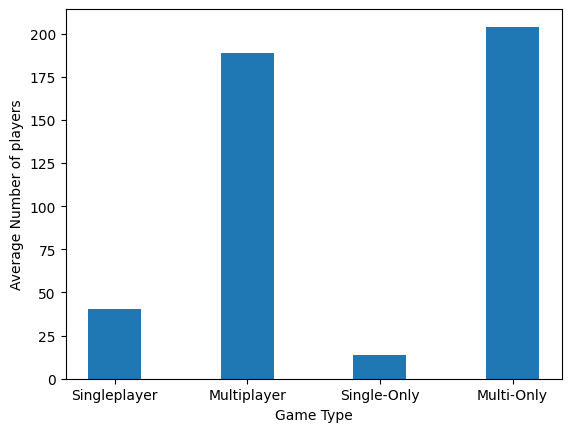

In [30]:
plot_games()

In [17]:
TTest_SPOnly_MPOnly_TheSame()

All Mp-Only games with playercount: 204
All Sp-Only games with playercount: 3689
T-statistic: -1.33056059939778, P-value: 0.18482522927944137
Mean player count for Multi-player Only games: 203.94607843137254
Mean player count for Single-player Only games: 13.640010843046896


In [20]:
TTest_SP_MPOnly_TheSame()

All Mp-Only games with playercount: 204
All Sp games with playercount: 4385
T-statistic: -1.1391182558775235, P-value: 0.25598408593038846
Mean player count for Multi-player Only games: 203.94607843137254
Mean player count for Single-player games: 40.680045610034206


In [18]:
TTest_SPOnly_MP_TheSame()

All Mp games with playercount: 900
All Sp-Only games with playercount: 3689
T-statistic: -3.1284753514085715, P-value: 0.0018134994764235934
Mean player count for Multi-player games: 188.5211111111111
Mean player count for Single-player Only games: 13.640010843046896


### Diskusia ku testu
Ako si môžeme všimnúť keď som provnal čisto singleplayer ku čisto multiplayerovým hrám, tak P-hodnota bola príliš vysoká aby som mohol vylúčili nulovú hypotézu. Takisto to vyšlo, ak predpokladám že všetky hry ktoré sú singleplayer majú len malý multiplayer komponent. 
Štatisticky signifikantná P-hodnota vyšla pri opačnom premýšlaní, keď som porovnal čisto singleplayer ku všetkým multiplayer hrám. Avšak, je to výsledok s obrovským predpokladom, ktorý ani nie je pravdivý. Hodila by sa teda nejaká štatistika, ktorá by hovorila ktorá zložka je pri ktorej hre väčšia, aby sme mohli hry priradiť do správnej kategórie. Tú nemám a tak sa musím uspokojiť len s týmito výsledkami.

### Koreluje vek hry s nižším počtom hráčov.
Pre tento test použijem linárnu regresiu. 


In [8]:
def convert_date(date_str):
    # Define month abbreviation to full name mapping
    month_abbr_to_full = {
        'Jan,': 'January',
        'Feb,': 'February',
        'Mar,': 'March',
        'Apr,': 'April',
        'May,': 'May',
        'Jun,': 'June',
        'Jul,': 'July',
        'Aug,': 'August',
        'Sep,': 'September',
        'Oct,': 'October',
        'Nov,': 'November',
        'Dec,': 'December'
    }
    
    # Replace month abbreviations with full names
    for month_abbr, month_full in month_abbr_to_full.items():
        date_str = date_str.replace(month_abbr, month_full)
    
    # Parse the date string to datetime object
    date_obj = datetime.strptime(date_str, '%d %B %Y')
    
    # Format the date to ISO 8601 (YYYY-MM-DD)
    iso_date = date_obj.date().isoformat()
    
    return datetime.strptime(iso_date, '%Y-%m-%d')

def get_game_age():
    current_date = datetime.now()
    ages = {}
    ls = get_apps_in_directory(games_directory)
    for file in ls:
        try:
            js = read_file_json(file, games_directory)
            date_info = js['release_date']
            if date_info['coming_soon'] == False:
                date_str = date_info['date']
                date = convert_date(date_str)
                age = (current_date - date)
                ages[str(js['steam_appid'])] = age.days
        except: pass
    return ages

def get_player_count_for_all_games() -> dict:
    with open(player_count_file, 'r') as c_f:
        measurements = json.load(c_f)
    return measurements

def join_dictionaries_on_key(dict1, dict2) -> list:
    result = [[], []]
    for key in dict1:
        if key in dict2:
            result[0].append(dict1[key])
            result[1].append(dict2[key])
    return result



def show_plot2D(x_label, y_label, title):
    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add legend
    plt.legend()

    # Display plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def LRegress_GameAgeToPlayerCount(player_count_min : int):
    ages = get_game_age()
    player_count = get_player_count_for_all_games()
    player_count = {key: value for key, value in player_count.items() if value >= player_count_min}
    values = join_dictionaries_on_key(ages, player_count)
    result = stats.linregress(values[0], values[1])
    print(result)
    
    slope, intercept, rvalue, pvalue, stderr = result
    
    predicted_player_counts = slope * np.array(values[0]) + intercept
    
    plt.scatter(values[0], values[1], color='blue', label='Data points')
    plt.plot(values[0], predicted_player_counts, color='red', label='Regression line')
    show_plot2D('Game Age (Days)', 'Player Count', 'Game Age vs. Player Count')

Ako si môžete všimnúť, pridal som tam aj možnosť nastaviť minimálny počet hráčov pre testy. To je aby som dokázal odfiltrovať hry, ktoré sú hlboko zakopané na Steam-e a nechal tam iba hrané hry. Myslím si že nehrané hry mi môžu pokaziť pozorovanú koreláciu.

LinregressResult(slope=0.009252583156674245, intercept=32.115978190473385, rvalue=0.014587050491896068, pvalue=0.3132585167791321, stderr=0.009174465788341768, intercept_stderr=17.389152726669693)


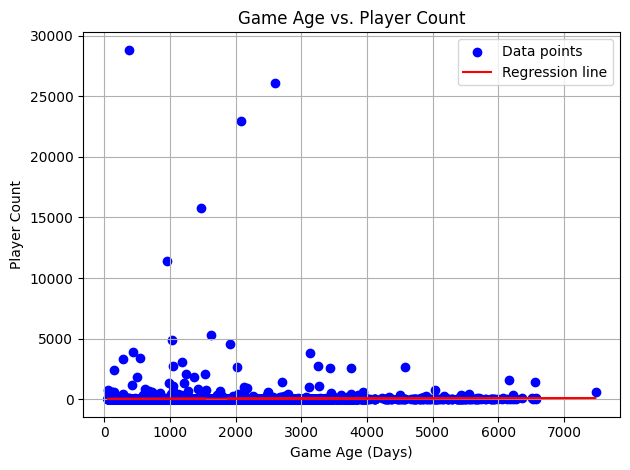

In [47]:
LRegress_GameAgeToPlayerCount(player_count_min = 0)

LinregressResult(slope=-0.33320554641084144, intercept=2926.295154352365, rvalue=-0.11680516994162908, pvalue=0.26749999879622105, stderr=0.298638550169248, intercept_stderr=832.7370715296074)


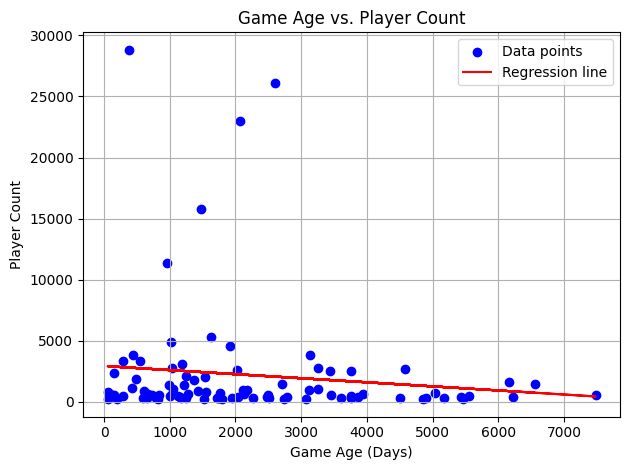

In [48]:
LRegress_GameAgeToPlayerCount(player_count_min = 200)

LinregressResult(slope=-0.7101111652973428, intercept=7927.001905590631, rvalue=-0.13220892736169138, pvalue=0.5287098901262366, stderr=1.1101266229818674, intercept_stderr=2628.077369247285)


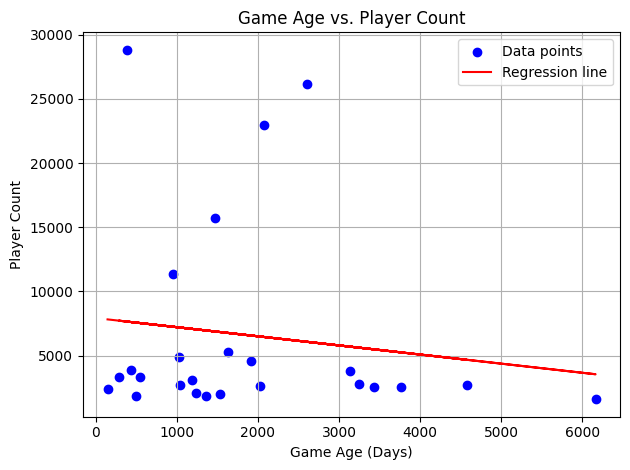

In [49]:
LRegress_GameAgeToPlayerCount(player_count_min = 1500)

### Diskusia ku testu
P-hodnota vo všetkých testoch bola príliš veľká, čo naznačuje minimálnu koreláciu medzi vekom hry a počtom hráčov. Aj keď sa pri zvyšovaní minimálneho počtu hráčov sklon priamky zväčšoval, čo bolo v súlade s očakávaniami, p-hodnota zostávala stále príliš vysoká na to, aby sme mohli hovoriť o významnej závislosti.

Tento výsledok môže naznačovať, že na počet hráčov má vplyv viacero faktorov, ktoré sú omnoho významnejšie než vek hry. Faktory ako pravidelné aktualizácie, popularita žánru, komunita okolo hry, a marketingové aktivity môžu mať väčší vplyv na udržanie alebo pokles počtu hráčov. Preto by ďalší výskum mohol zahrnúť tieto premenné, aby lepšie porozumel počtu hráčov v závislosti na veku hry.

### Korešponduje priemerný počet hráčov na žáner s percentom hier spravených na daný žáner.

Toto otestujem štatistickou metódou zvanou test dobrej zhody. Podobne ako pri singleplayer vs multiplayer hrách, aj tu je podobný problém. Jedna hra môže mať niekolko žánrov. Rozhodol som sa to ale ignorovať a hry, ktoré patria do viacej žánrou prideliť pre každý žáner zvlášť. <br>
Následne niektoré žanre ktoré steam píše ako žánre nie sú velmi žánre. Po analýze všetkych dát ktoré mám som sa rozhodol nechať len zopár žánrov.
Je to síce menej žánrov, ako réalne existuje, ale sú to všetky herné žánre v mojich testovacích dátach.

In [9]:
FILTERED_GENRES = [
    1,  # Action 
    25, # Adventure
    23, # Indie
    3,  # RPG 
    4,  # Casual
    2,  # Strategy
    28, # Simulation
    29, # MMO
    9,  # Racing
    18  # Sports 
]

In [10]:
def get_games_in_genres() -> dict:
    games_in_genre = dict()
    ls = get_apps_in_directory(games_directory)
    for file in ls:
        try:
            js = read_file_json(file, games_directory)
            genres = js['genres']
            for genre in genres:
                if genre['id'] in games_in_genre:
                    games_in_genre[genre['id']] += 1
                else:
                    games_in_genre[genre['id']] = 1
        except: pass
    return games_in_genre

def get_all_genres() -> dict:
    all_genres = dict()
    ls = get_apps_in_directory(games_directory)
    for file in ls:
        try:
            js = read_file_json(file, games_directory)
            genres = js['genres']
            for genre in genres:
                if genre['id'] not in all_genres:
                    all_genres[genre['id']] = genre['description']
        except: pass
    return all_genres


def get_player_count_on_genre() -> dict:
    p_count = get_player_count_for_all_games()
    players_in_genre = dict()
    for key in p_count.keys():
         try:
            js = read_file_json(str(key) +'.txt', games_directory)
            genres = js['genres']
            for genre in genres:
                if genre['id'] in players_in_genre:
                    players_in_genre[genre['id']] += p_count[key]
                else:
                    players_in_genre[genre['id']] = p_count[key]
         except: pass
    return players_in_genre

def pearson_games_on_genre_to_playercount(observed: dict, expected: dict):
    for key in observed.keys(): 
        if key not in expected.keys(): expected[key] = 0
    
    for key in expected.keys(): 
        if key not in observed.keys(): observed[key] = 0
                
    keys = expected.keys()
    table = [[observed[key] for key in keys],
             [expected[key] for key in keys]]
    
    statistics, pvalue = stats.chisquare(table[0], table[1])
    #statistic, pvalue, dof, expected_freq = stats.chi2_contingency(table)
    print("Statistics" + str(statistics))
    print("P Value: " + str(pvalue))


In [22]:
FILTERED_GENRES_CONV = {
    '1':  "Action", 
    '25': "Adventure",
    '23': "Indie",
    '3':  "RPG", 
    '4':  "Casual",
    '2':  "Strategy",
    '28': "Simulation",
    '29': "MMO",
    '9':  "Racing",
    '18': "Sports", 
}


def show_genres_in_pie_chart(genres, title = ""):
    labels, sizes = [], []
    for key in genres.keys():
        labels.append(FILTERED_GENRES_CONV[key])
        sizes.append(genres[key])
    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels)
    plt.title(title)
    plt.show()


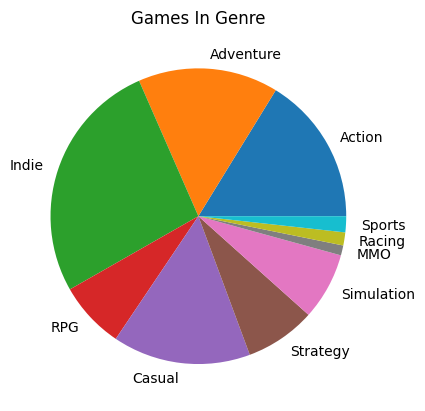

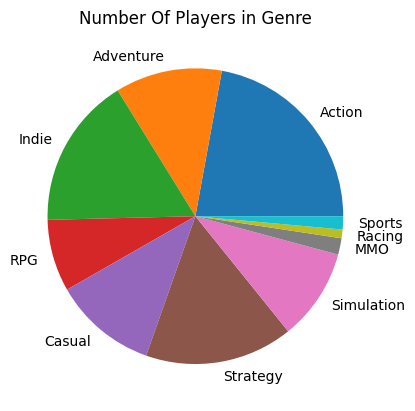

In [23]:
gg = get_games_in_genres()
gg_filtered = { key: value for key, value in gg.items() if int(key) in FILTERED_GENRES }
gg_sum = np.array(list(gg_filtered.values())).sum()
gg_filtered_norm = { key: value/gg_sum for key, value in gg_filtered.items() }
show_genres_in_pie_chart(gg_filtered, "Games In Genre")

pg = get_player_count_on_genre()
pg_filtered = { key: value for key, value in pg.items() if int(key) in FILTERED_GENRES }
pg_sum = np.array(list(pg_filtered.values())).sum()
pg_filtered_norm = { key: value/pg_sum for key, value in pg_filtered.items() }
show_genres_in_pie_chart(pg_filtered, "Number Of Players in Genre")

Grafy oboch vyzerajú dosť podobne. Očakávam že P hodnota bude tomu zodpovedať. 

In [12]:
pearson_games_on_genre_to_playercount(observed = pg_filtered_norm, expected = gg_filtered_norm)

Statistics0.1876448455762081
P Value: 0.9999995800196086


Očakával som velkú P-hodnotu, ale nie až takto velkú. Momentálne som meral počet všetkých hráčov na žáner k počtu hrám. Čím viac hier, tým viac hráčov. Čo sa stane ak zoberiem priemerný počet hráčov...

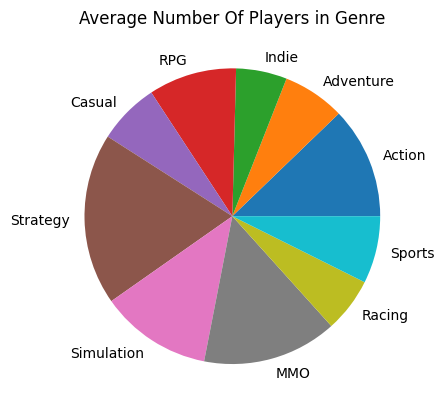

In [24]:
pg_filtered = { key: value / gg[key] for key, value in pg.items() if int(key) in FILTERED_GENRES }
pg_sum = np.array(list(pg_filtered.values())).sum()
pg_filtered_norm = { key: value/pg_sum for key, value in pg_filtered.items() }
show_genres_in_pie_chart(pg_filtered, "Average Number Of Players in Genre")

In [14]:
pearson_games_on_genre_to_playercount(observed = pg_filtered_norm, expected = gg_filtered_norm)

Statistics2.499186071779669
P Value: 0.9809053725312855


Stále je P-hodnota príliš vysoká. Verím SciPi testom, ale aj tak si to vyskúšam prepočítať manuálne.

In [18]:
chi_arr = [ (pg_filtered_norm[key] - exp)**2 / exp for key, exp in gg_filtered_norm.items() ]
chi_stat = np.sum(chi_arr)
print("Chi-Stat: " + str(chi_stat))
pvalue = 1 - stats.chi2.cdf(x = chi_stat, df = (len(gg.keys())-1))
print("Pvalue: " + str(pvalue))
critical_val = stats.chi2.ppf(q = 0.95, df = (len(gg.keys())-1))
print("Critical Value: " + str(critical_val))

Chi-Stat: 2.499186071779669
Pvalue: 0.9999999970100613
Critical Value: 37.65248413348277


Ako sa očakávalo SciPi testy sa nemýlili. Je zaujímavé že mi vyšla iná P-hodnota, aj keď štatistika mi vyšla rovnaká. Každopádne na výsledku to nič nemení.

### Diskusia ku testu
Test dobrej zhody ukázal silnú zhodu medzi počtom hráčov a počtom hier na žáner. Prvotne som si myslel že to je spôsobené tým že s počtom hier sa zvyšuje počet hráčov, ale vyvrátilo sa mi to keď som počítal s priemerným počtom hráčov. Vyzerá že trh sa prispôsobil dopytu.

## Diskusia

V tejto práci som otestoval 3 hypotézy. 
- Bohužial pri prvom teste, ktorý testoval rovnost počtu hráčov hrajúcich singleplayer a multiplayer hry som nedokázal konfidentne potvrdiť alebo vyvrátiť nulovú hypotézu, keďže potrebujem omnoho viac údajov.
- Pri teste ktorý testoval koreláciu medzi vekom hry a počtom hráčov som dokázal vyvrátiť nulovú hypotézu. Síce sklon regresnej priamky bol v súlade s hypotézou, P-hodnota bola príliš malá.
- Na záver som ešte otestoval dobrú zhodu medzi počtom hier a počtom hráčov na žáner. Pri tomto teste som získal príliš vysokú p-hodnotu a tak nemôžem zamietnuť nulovú hypotézu.